### 数据预处理

In [1]:
import os
import re
from collections import Counter
from email import parser, policy
from html import unescape

import nltk
import pandas
import urlextract
from nltk.corpus import stopwords
from sklearn import metrics, preprocessing, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from email.parser import BytesParser

import joblib
# import sys
# print(sys.executable)

In [7]:
# 读取数据集
INDEX_PATH = os.path.join('trec07p', 'full', 'index')  # 先使用较小的数据集进行训练
DATA_PATH = os.path.join('trec07p', 'data')  # 数据文件夹路径
labels = []
filenames = []

In [8]:
# 将delay中的标签和对应的文件名保存
def create_dataset(index_path):
    with open(index_path) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.split(' ')
            labels.append(line[0])
            filenames.append(line[1].strip('\n').split('/')[-1])
            
create_dataset(INDEX_PATH)

In [9]:
# 下载delay中索引的文件内容
def load_email(filename, file_path):
    with open(os.path.join(file_path, filename), 'rb') as f:
        return parser.BytesParser(policy=policy.default).parse(f)

raw_emails = [load_email(name, DATA_PATH) for name in filenames]

In [6]:
# print(raw_emails[3].get_content().strip())  # 打印邮件文本内容，注意这里输出内容不一定是正确的，只有当邮件为文本类型，才能输出；不能正确输出说明邮件是多部份的

In [7]:
# 数据预处理
# 构造函数获取邮件的结构类型及其计数

# 确定每封电子邮件的结构类型
def get_email_structure(email):
    if isinstance(email, str): # 字符串直接返回
        return email
    payload = email.get_payload() # 提取email的主体部分
    if isinstance(payload, list): # 如果是列表，说明该邮件为多部份
        return 'multipart({})'.format(', '.join([get_email_structure(sub_email) for sub_email in payload]))
        # 如果有两个子部分，一个是 text/plain，另一个是 text/html，那么最终的结果将是 'multipart(text/plain, text/html)'
    else: # 否则一般是text/plain或text/html
        return email.get_content_type()

In [8]:
# 统计一组电子邮件中各种结构类型的出现次数
def structures_counter(emails):
    structures = Counter() # 字典类型
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [9]:
print(structures_counter(raw_emails).most_common())  # 显示邮件包含的类型
"""
这对于分析电子邮件数据集的结构分布非常有用，可以帮助我们理解数据集中最常见的电子邮件类型，从而为进一步的数据处理和特征工程提供信息。
例如，如果多数邮件都是纯文本类型，那么我们可能会专注于文本内容的分析；如果有大量的多部分邮件，我们可能需要考虑如何处理嵌入的图片或附件。
"""

[('text/plain', 29989), ('multipart(text/plain, text/html)', 17496), ('text/html', 11978), ('multipart(multipart(text/plain, text/html), image/gif)', 5066), ('multipart(text/html)', 3741), ('multipart(multipart(text/plain, text/html), image/jpeg)', 2510), ('multipart(text/html, image/gif)', 1021), ('multipart(text/plain)', 682), ('multipart(text/plain, application/pgp-signature)', 595), ('multipart(text/plain, text/plain)', 398), ('multipart(multipart(text/plain, text/html), image/png)', 240), ('multipart(multipart(text/plain, text/html))', 151), ('multipart(multipart(text/plain, text/html), text/plain)', 135), ('multipart(text/html, text/plain, image/png)', 122), ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/jpeg, application/octet-stream)', 116), ('multipart(text/plain charset=us-ascii, text/html)', 108), ('multipart(text/plain, application/octet-stream)', 75), ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/gif, image/gif, applic

'\n这对于分析电子邮件数据集的结构分布非常有用，可以帮助我们理解数据集中最常见的电子邮件类型，从而为进一步的数据处理和特征工程提供信息。\n例如，如果多数邮件都是纯文本类型，那么我们可能会专注于文本内容的分析；如果有大量的多部分邮件，我们可能需要考虑如何处理嵌入的图片或附件。\n'

In [10]:
# 将原始的电子邮件内容转换为更适合文本分析和机器学习模型训练的格式

# 将HTML内容转换为纯文本，同时替换为相应的关键词
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub(r'<[aA]\s.*?>', 'HYPERLINK', text, flags=re.M | re.S | re.I)
    text = re.sub(r'<img\s.*?>', 'IMAGE', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [11]:
# 用于从电子邮件中提取文本内容
def email_to_text(email):
    html = None
    # walk()打印出一封具有多部分结构之信息的每个部分的MIME类型
    for part in email.walk():
        ctype = part.get_content_type()
        if ctype not in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except LookupError:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [12]:
# 下载 stopwords 资源
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86180\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# 分词
stopwords_list = stopwords.words('english')  # 英文停用词列表
token = nltk.stem.SnowballStemmer('english')  # 提取词干，词干提取器对象，用于将单词还原为基本形式或词干。例如，将“running”还原为“run”。

# 将所有小写英文字母添加到停用词列表
for single in range(97, 123):
    stopwords_list.append(chr(single))
    
extractor = urlextract.URLExtract() # 创建了一个URL提取器对象，用于从文本中找出URL

In [14]:
# 将电子邮件文本转换为一个清洗和标准化的单词列表
def word_split(email):
    text = email_to_text(email) or ' '
    text = text.lower()
    text = re.sub(r'\W+', ' ', text, flags=re.M) # 使用正则表达式替换文本中的所有非字母数字字符为单个空格
    urls = list(set(extractor.find_urls(text))) # 一个去重的URL列表
    urls.sort(key=lambda item: len(item), reverse=True) # 将找到的URL按长度降序排序
    for url in urls:
        text = text.replace(url, "URL") # 将文本中的所有URL替换为特征词“URL”
    text = re.sub(r'\d+(?:\.\d*[eE]\d+)?', 'NUMBER', text) # 使用正则表达式将文本中的所有数字替换为字符串“NUMBER”
    content = list(nltk.word_tokenize(text)) # 使用NLTK的 word_tokenize 函数将文本分割成单词列表
    all_words = []
    for word in content:
        if word not in stopwords_list:
            word = token.stem(word)
            all_words.append(word)
    return all_words

In [15]:
# 下载 punkt 资源
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86180\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
all_emails = [word_split(data) for data in raw_emails]

In [17]:
print(all_emails[1])  # 查看分词结果

['hi', 'updat', 'gulus', 'check', 'mirror', 'seem', 'littl', 'typo', 'debian', 'readm', 'file', 'exampl', 'http', 'gulus', 'usherbrook', 'ca', 'debian', 'readm', 'ftp', 'ftp', 'fr', 'debian', 'org', 'debian', 'readm', 'test', 'lenni', 'access', 'releas', 'dist', 'test', 'current', 'test', 'develop', 'snapshot', 'name', 'etch', 'packag', 'test', 'unstabl', 'pass', 'autom', 'test', 'propog', 'releas', 'etch', 'replac', 'lenni', 'like', 'readm', 'html', 'yan', 'morin', 'consult', 'en', 'logiciel', 'libr', 'yan', 'morin', 'savoirfairelinux', 'com', 'number', 'number', 'number', 'unsubscrib', 'email', 'debian', 'mirror', 'request', 'list', 'debian', 'org', 'subject', 'unsubscrib', 'troubl', 'contact', 'listmast', 'list', 'debian', 'org']


In [30]:
# 保存处理结果，方便后面直接使用
import json
# 将预处理后的邮件数据保存到JSON文件
with open('preprocessed_trec07p_emails.json', 'w', encoding='utf-8') as jsonfile:
    json.dump(all_emails, jsonfile, ensure_ascii=False, indent=4)

with open('preprocessed_trec07p_labels_emails.json', 'w', encoding='utf-8') as jsonfile:
    json.dump(labels, jsonfile, ensure_ascii=False, indent=4)

### 特征提取

In [2]:
import json
with open('data/preprocessed_data/preprocessed_trec07p_emails.json', 'r', encoding='utf-8') as jsonfile:
    all_emails = json.load(jsonfile)

with open('preprocessed_trec07p_labels_emails.json', 'r', encoding='utf-8') as jsonfile:
    labels = json.load(jsonfile)

In [3]:
import pandas
# 特征提取
# 创建一个dataframe，列名为text和label
trainDF = pandas.DataFrame()
trainDF['text'] = all_emails
trainDF['label'] = labels

In [4]:
# 将数据集分为训练集和测试集，以便模型能在训练集上学习并在测试集上验证其性能
# sklearn.model_selection.train_test_split
train_data, test_data, train_label, test_label = train_test_split(trainDF['text'],trainDF['label'], random_state=0)

In [5]:
# label编码为目标变量,即从字符串转为一个数字
# sklearn.preprocessing
encoder = preprocessing.LabelEncoder()
train_label = encoder.fit_transform(train_label)
test_label = encoder.fit_transform(test_label)

In [6]:
trainDF['text'] = [' '.join(email) for email in all_emails]
train_data = [' '.join(doc) for doc in train_data]
test_data = [' '.join(doc) for doc in test_data]

In [7]:
# 4.1 计数特征向量
# sklearn.feature_extraction.text.CountVectorizer
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
count_vect.fit(trainDF['text'])
xtrain_count = count_vect.transform(train_data)  # 训练集特征向量
xtest_count = count_vect.transform(test_data)  # 测试集特征向量

### 计数特征向量模型训练

In [17]:
# 分类任务
# 创建分类器
# sklearn.metrics
def train_model(classifier, train_feature, train_label, test_feature, test_label):
    classifier.fit(train_feature, train_label)
    prediction = classifier.predict(test_feature)
    acc = metrics.accuracy_score(prediction, test_label)
    prec = metrics.precision_score(test_label, prediction, average='weighted')
    rec = metrics.recall_score(test_label, prediction, average='weighted')
    f1 = metrics.f1_score(test_label, prediction, average='weighted')
    return acc, prec, rec, f1

In [18]:
# 5.1 朴素贝叶斯多项式模型
# 5.1.1 计数特征向量
# Sklearn.naive_bayes
# accuracy, precision, recall, f1_socre = train_model(naive_bayes.MultinomialNB(), xtrain_count, xtest_count)
# print("NB, Count Vectors: ", accuracy)
accuracy, precision, recall, f1_score = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_label, xtest_count, test_label)
print("MulNB, Count Vectors: ", accuracy, precision, recall, f1_score)

MulNB, Count Vectors:  0.9474940334128878 0.9533117833742231 0.9474940334128878 0.9482460458748498


In [19]:
model = naive_bayes.MultinomialNB()
model.fit(xtrain_count, train_label)
# 使用测试集的特征向量进行预测
predictions = model.predict(xtest_count)
# 使用测试集的标签来计算评估指标
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')
print("MulNB, Count Vectors: ", accuracy, precision, recall, f1_score)
# 保存模型
joblib.dump(model, 'MulNB_model.pkl')
# 保存向量化器
joblib.dump(count_vect, 'MulNB_vectorizer.pkl')

MulNB, Count Vectors:  0.9474940334128878 0.9533117833742231 0.9474940334128878 0.9482460458748498


['MulNB_vectorizer.pkl']

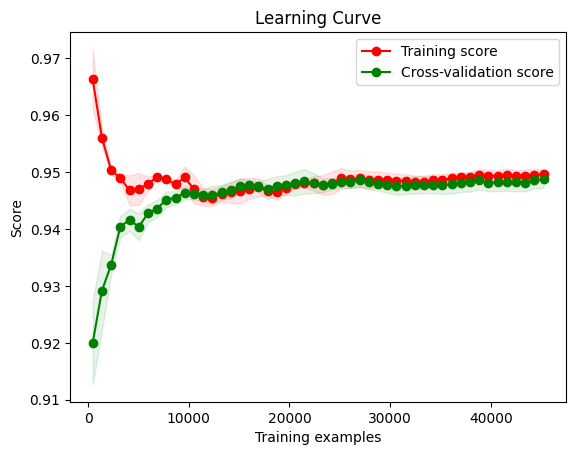

In [49]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
# 初始化模型
model = MultinomialNB()
# 使用learning_curve函数来获取训练集大小、训练分数和验证分数
train_sizes, train_scores, validation_scores = learning_curve(
    model, xtrain_count, train_label, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))
# 计算平均和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
# 绘制学习曲线
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
# 绘制训练分数曲线
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
# 绘制验证分数曲线
# plt.ylim([0.9, 1.0])
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score', color='g', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.legend(loc='best')
plt.show()

In [21]:
# 5.2 朴素贝叶斯伯努利模型
# 5.2.1 计数特征向量
accuracy, precision, recall, f1_socre = train_model(naive_bayes.BernoulliNB(), xtrain_count, train_label, xtest_count, test_label)
print("BernliNB, Count Vectors: ", accuracy, precision, recall, f1_score)

BernliNB, Count Vectors:  0.9417130734553169 0.9450809618666205 0.9417130734553169 0.9482460458748498


In [22]:
model = naive_bayes.BernoulliNB()
model.fit(xtrain_count, train_label)
# 使用测试集的特征向量进行预测
predictions = model.predict(xtest_count)
# 使用测试集的标签来计算评估指标
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')
print("BernliNB, Count Vectors: ", accuracy, precision, recall, f1_score)
# 保存模型
joblib.dump(model, 'BernliNB_model.pkl')
# 保存向量化器
joblib.dump(count_vect, 'BernliNB_vectorizer.pkl')

BernliNB, Count Vectors:  0.9417130734553169 0.9450809618666205 0.9417130734553169 0.9423320892940653


['BernliNB_vectorizer.pkl']

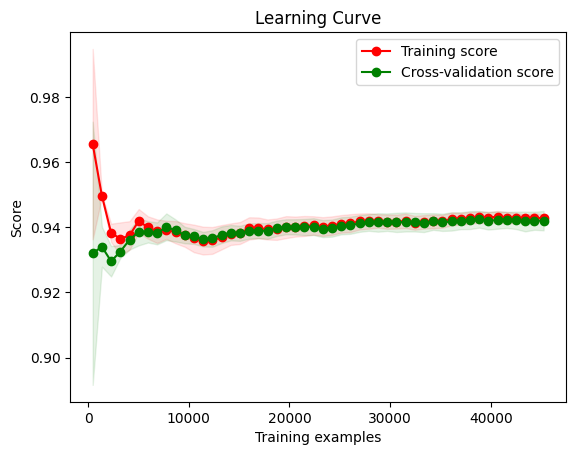

In [45]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
# 初始化模型
model = BernoulliNB()
# 使用learning_curve函数来获取训练集大小、训练分数和验证分数
train_sizes, train_scores, validation_scores = learning_curve(
    model, xtrain_count, train_label, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))
# 计算平均和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
# 绘制学习曲线
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
# 绘制训练分数曲线
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
# 绘制验证分数曲线
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score', color='g', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.legend(loc='best')
plt.show()

In [23]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(xtrain_count, train_label)
# 使用测试集的特征向量进行预测
predictions = model.predict(xtest_count)
# 使用测试集的标签来计算评估指标
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')
print("CompleNB, Count Vectors: ", accuracy, precision, recall, f1_score)
# 保存模型
joblib.dump(model, 'CompleNB_model.pkl')
# 保存向量化器
joblib.dump(count_vect, 'CompleNB_vectorizer.pkl')

CompleNB, Count Vectors:  0.9030495889684433 0.9227947035288852 0.9030495889684433 0.9052868949559476


['CompleNB_vectorizer.pkl']

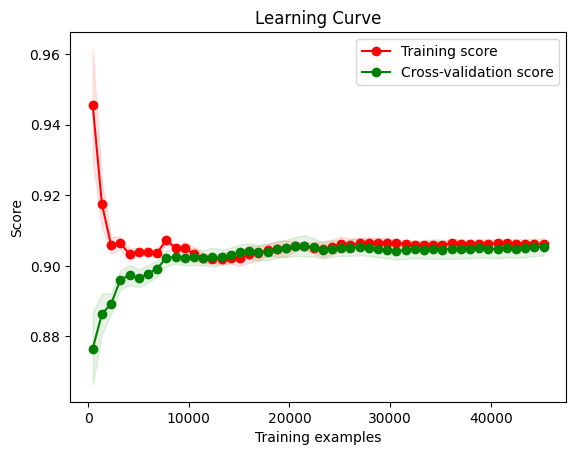

In [50]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
# 初始化模型
model = ComplementNB()
# 使用learning_curve函数来获取训练集大小、训练分数和验证分数
train_sizes, train_scores, validation_scores = learning_curve(
    model, xtrain_count, train_label, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))
# 计算平均和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
# 绘制学习曲线
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
# 绘制训练分数曲线
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
# 绘制验证分数曲线
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score', color='g', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.legend(loc='best')
plt.show()

In [24]:
# 5.3 SVM
# 5.3.1 计数特征向量 sklearn.svm
from sklearn import svm
accuracy, precision, recall, f1_socre = train_model(svm.SVC(), xtrain_count, train_label, xtest_count, test_label)
print("SVM, Count Vectors: ", accuracy, precision, recall, f1_score)

SVM, Count Vectors:  0.9810129939008221 0.98133233655503 0.9810129939008221 0.9052868949559476


In [25]:
model = svm.SVC()
model.fit(xtrain_count, train_label)
# 使用测试集的特征向量进行预测
predictions = model.predict(xtest_count)
# 使用测试集的标签来计算评估指标
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')
print("SVM, Count Vectors: ", accuracy, precision, recall, f1_score)
# 保存模型
joblib.dump(model, 'SVM_model.pkl')
# 保存向量化器
joblib.dump(count_vect, 'SVM_vectorizer.pkl')

SVM, Count Vectors:  0.9810129939008221 0.98133233655503 0.9810129939008221 0.9808961735636577


['SVM_vectorizer.pkl']

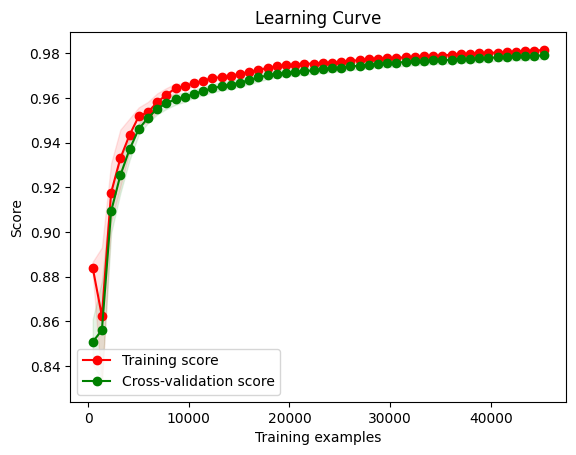

In [51]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import svm
# 初始化模型
model = svm.SVC()
# 使用learning_curve函数来获取训练集大小、训练分数和验证分数
train_sizes, train_scores, validation_scores = learning_curve(
    model, xtrain_count, train_label, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))
# 计算平均和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
# 绘制学习曲线
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
# 绘制训练分数曲线
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
# 绘制验证分数曲线
# plt.ylim([0.9, 1.0])
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score', color='g', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.legend(loc='best')
plt.show()

In [26]:
# 5.4 随机森林 sklearn.ensemble
# 5.4.1 计数特征向量
from sklearn import ensemble
accuracy, precision, recall, f1_socre = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_label, xtest_count, test_label)
print("RFCF, Count Vectors: ", accuracy, precision, recall, f1_score)

RFCF, Count Vectors:  0.9934234950941395 0.9934231441210174 0.9934234950941395 0.9808961735636577


In [27]:
model = ensemble.RandomForestClassifier()
model.fit(xtrain_count, train_label)
# 使用测试集的特征向量进行预测
predictions = model.predict(xtest_count)
# 使用测试集的标签来计算评估指标
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')
print("RFCF, Count Vectors: ", accuracy, precision, recall, f1_score)
# 保存模型
joblib.dump(model, 'RFCF_model.pkl')
# 保存向量化器
joblib.dump(count_vect, 'RFCF_vectorizer.pkl')

RFCF, Count Vectors:  0.9932643861044815 0.9932627647952876 0.9932643861044815 0.9932597318634506


['RFCF_vectorizer.pkl']

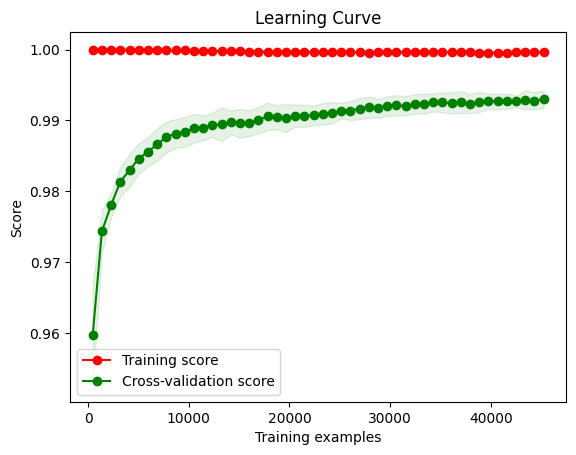

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import ensemble
# 初始化模型
model = ensemble.RandomForestClassifier()
# 使用learning_curve函数来获取训练集大小、训练分数和验证分数
train_sizes, train_scores, validation_scores = learning_curve(
    model, xtrain_count, train_label, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))
# 计算平均和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
# 绘制学习曲线
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
# 绘制训练分数曲线
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
# 绘制验证分数曲线
# plt.ylim([0.9, 1.0])
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score', color='g', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.legend(loc='best')
plt.show()

In [28]:
# 5.5 KNN sklearn.neighbors
# 5.5.1 计数特征向量
from sklearn import neighbors
accuracy, precision, recall, f1_socre = train_model(neighbors.KNeighborsClassifier(), xtrain_count, train_label, xtest_count, test_label)
print("KNN, Count Vectors: ", accuracy, precision, recall, f1_score)

KNN, Count Vectors:  0.960381861575179 0.9618299643064191 0.960381861575179 0.9932597318634506


In [29]:
model = neighbors.KNeighborsClassifier()
model.fit(xtrain_count, train_label)
# 使用测试集的特征向量进行预测
predictions = model.predict(xtest_count)
# 使用测试集的标签来计算评估指标
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')
print("KNN, Count Vectors: ", accuracy, precision, recall, f1_score)
# 保存模型
joblib.dump(model, 'KNN_model.pkl')
# 保存向量化器
joblib.dump(count_vect, 'KNN_vectorizer.pkl')

KNN, Count Vectors:  0.960381861575179 0.9618299643064191 0.960381861575179 0.9598216600378414


['KNN_vectorizer.pkl']

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import neighbors
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import ensemble
# 初始化模型
model = neighbors.KNeighborsClassifier()
# 使用learning_curve函数来获取训练集大小、训练分数和验证分数
train_sizes, train_scores, validation_scores = learning_curve(
    model, xtrain_count, train_label, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))
# 计算平均和标准差
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
# 绘制学习曲线
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
# 绘制训练分数曲线
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
# 绘制验证分数曲线
# plt.ylim([0.9, 1.0])
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score', color='g', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.legend(loc='best')
plt.show()

### TF-IDF特征向量模型训练

In [8]:
# 4.2 TF-IDF特征向量
# sklearn.feature_extraction.text.TfidfVectorizer
# 4.2.1 词语级
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
# 4.2.2 多词语级
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2, 3), max_features=5000)
# 4.2.3 词性级
tfidf_vect_char = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=5000)

In [9]:
# 拟合向量化器并转换文本数据
xtrain_tfidf = tfidf_vect.fit_transform(train_data)
xtest_tfidf = tfidf_vect.transform(test_data)

In [10]:
# 使用转换后的特征向量训练一个机器学习模型
# TF-IDF特征向量+朴素贝叶斯多项式模型
from sklearn import naive_bayes
model = naive_bayes.MultinomialNB()
model.fit(xtrain_tfidf, train_label)

MultinomialNB()

In [15]:
# 在测试集上评估模型性能
# from sklearn import metrics
predictions = model.predict(xtest_tfidf)
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')

In [16]:
# 打印性能指标
print("MulNB, Count Vectors: ", accuracy, precision, recall, f1_score)

MulNB, Count Vectors:  0.9697162556351101 0.9705368600001902 0.9697162556351101 0.9698780660892267


In [17]:
# 保存模型
joblib.dump(model, 'MulNB_tfidf_model.pkl')
# 保存向量化器
joblib.dump(tfidf_vect, 'MulNB_tfidf_vectorizer.pkl')

['MulNB_tfidf_vectorizer.pkl']

In [18]:
# TF-IDF特征向量+朴素贝叶斯伯努利模型
model = naive_bayes.BernoulliNB()
model.fit(xtrain_tfidf, train_label)

predictions = model.predict(xtest_tfidf)
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')

print("BernliNB, Count Vectors: ", accuracy, precision, recall, f1_score)

BernliNB, Count Vectors:  0.9430389817024661 0.9461390201505122 0.9430389817024661 0.9436189592697025


In [19]:
# 保存模型
joblib.dump(model, 'BernliNB_tfidf_model.pkl')
# 保存向量化器
joblib.dump(tfidf_vect, 'BernliNB_tfidf_vectorizer.pkl')

['BernliNB_tfidf_vectorizer.pkl']

In [11]:
from sklearn import svm
# TF-IDF特征向量+SVM
model = svm.SVC()
model.fit(xtrain_tfidf, train_label)

predictions = model.predict(xtest_tfidf)
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')

print("SVM, Count Vectors: ", accuracy, precision, recall, f1_score)

SVM, Count Vectors:  0.9952267303102625 0.9952443554130407 0.9952267303102625 0.9952200875897811


In [12]:
# 保存模型
joblib.dump(model, 'SVM_tfidf_model.pkl')
# 保存向量化器
joblib.dump(tfidf_vect, 'SVM_tfidf_vectorizer.pkl')

['SVM_tfidf_vectorizer.pkl']

In [13]:
# TF-IDF特征向量+随机森林
from sklearn import ensemble
from sklearn import metrics
model = ensemble.RandomForestClassifier()
model.fit(xtrain_tfidf, train_label)

predictions = model.predict(xtest_tfidf)
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')

print("RFCF, Count Vectors: ", accuracy, precision, recall, f1_score)

RFCF, Count Vectors:  0.9933704587642536 0.9933720031824423 0.9933704587642536 0.9933642924690371


In [14]:
# 保存模型
joblib.dump(model, 'RFCF_tfidf_model.pkl')
# 保存向量化器
joblib.dump(tfidf_vect, 'RFCF_tfidf_vectorizer.pkl')

['RFCF_tfidf_vectorizer.pkl']

In [16]:
# TF-IDF特征向量+KNN
from sklearn import neighbors
model = neighbors.KNeighborsClassifier()
model.fit(xtrain_tfidf, train_label)

predictions = model.predict(xtest_tfidf)
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')

print("KNN, Count Vectors: ", accuracy, precision, recall, f1_score)

C:\ANACONDA\envs\py38\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ANACONDA\envs\py38\lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\ANACONDA\envs\py38\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\ANACONDA\envs\py38\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ANACONDA\envs\py38\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


KNN, Count Vectors:  0.9505171042163882 0.9534347501500852 0.9505171042163882 0.949506438671592


In [17]:
# 保存模型
joblib.dump(model, 'KNN_tfidf_model.pkl')
# 保存向量化器
joblib.dump(tfidf_vect, 'KNN_tfidf_vectorizer.pkl')

['KNN_tfidf_vectorizer.pkl']

In [18]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(xtrain_count, train_label)
# 使用测试集的特征向量进行预测
predictions = model.predict(xtest_count)
# 使用测试集的标签来计算评估指标
accuracy = metrics.accuracy_score(test_label, predictions)
precision = metrics.precision_score(test_label, predictions, average='weighted')
recall = metrics.recall_score(test_label, predictions, average='weighted')
f1_score = metrics.f1_score(test_label, predictions, average='weighted')
print("CompleNB, Count Vectors: ", accuracy, precision, recall, f1_score)
# 保存模型
joblib.dump(model, 'CompleNB_tfidf_model.pkl')
# 保存向量化器
joblib.dump(count_vect, 'CompleNB_tfidf_vectorizer.pkl')

CompleNB, Count Vectors:  0.9030495889684433 0.9227947035288852 0.9030495889684433 0.9052868949559476


['CompleNB_tfidf_vectorizer.pkl']